Solve the Poisson equation on a square domain.  That is, find $u:\Omega \rightarrow \Re$ such that
$$
-\nabla \cdot \left[A\nabla u \right] + r(x) = 0
$$
on 
$$
\Omega = [0,1] \times [0,1]
$$
where $A$ is constant, and $r(x)$ is a function of space only.

In [1]:
from proteus.iproteus import * #pull in what we need for using proteus interactively

Define the PDE by defining the coefficients

In [2]:
class Poisson(TransportCoefficients.TC_base):
    """
    The coefficients of the Poisson equation 
    """
    def __init__(self,A,rofx):
        TransportCoefficients.TC_base.__init__(self, 
                         nc=1, #number of components
                         variableNames=['u'],
                         diffusion = {0:{0:{0:'constant'}}},#constant means not a function of the solution
                         potential = {0:{0:'u'}}, #define the potential for the diffusion term to be the solution itself
                         reaction  = {0:{0:'constant'}})
        self.A=A;
        self.rofx=rofx
        
    def evaluate(self,t,c):
        """
        evaluate quadrature point values held in the dictionary c
        These are labelled according to the 'master equation.' For example,
         
        c[('a',0,0)] = diffusion coefficient for the 0th equation (first) with respect to the
                       0th potential (the solution itself)
                       The value at each quadrature point is a n_d x n_d tensor (n_d=number of space dimensions).
                       Usually the tensor values are stored as a flat array in compressed sparse row format to save space. 
                       By default, we assume the tensor is full though.
                       
        c[('r',0)]   = reaction term for the 0th equation. This is where we will put the source term
        """
        #diffusion coefficient
        c[('a',0,0)][...,0] = self.A[0][0]
        c[('a',0,0)][...,3] = self.A[1][1]
        #reaction, 'x' is the spatial coordinate. It is always 3d
        c[('r',0)][:]     = self.rofx(c['x'][:])

Setup the problem to have a solution

$$
u(x_0,x_1) = \cos(2\pi x_0)\sin(2\pi x_0)\cos(2\pi x_1)\sin(2\pi x_1)
$$

or

$$
u(x_0,x_1) = x_0(1-x_0)x_1(1-x_1)
$$

For fun, we can take advantage of sage's symbolic calculus to calculate the correct expression for $r$.

Define the python functions for evaluating the terms. Note that the x array for the quadrature points will be a

multidimensional array. The last dimension will be 3 always though.

In [3]:
#use numpy for evaluations
import numpy as np
a0 = 1.0
def uex0(x):
    """
    exact solution: 
\[
u(x_0,x_1) = \cos(2\pi x_0)\sin(2\pi x_0)\cos(2\pi x_1)\sin(2\pi x_1)
\]
    """
    pi2=2.0*np.pi    
    return np.cos(pi2*x[...,0])*np.sin(pi2*x[...,0])*np.cos(pi2*x[...,1])*np.sin(pi2*x[...,1])
def rofx0(x):
    """
    r term for 
\[
u(x_0,x_1) = \cos(2\pi x_0)\sin(2\pi x_0)\cos(2\pi x_1)\sin(2\pi x_1)
\]

    """
    pi2=2.0*np.pi    
    return -32.*np.pi*np.pi*a0*np.sin(pi2*x[...,0])*np.sin(pi2*x[...,1])*np.cos(pi2*x[...,0])*np.cos(pi2*x[...,1])
#just illustrate numpy notation
x = np.arange(3*2*3).reshape(3,2,3)
print 'x.shape= ',x.shape,'\n x=\n',x
print 'x[...,0].shape= ',x[...,0].shape,'\n x[...,0]=\n',x[...,0]
print 'x[...,1].shape= ',x[...,1].shape,'\n x[...,1]=\n',x[...,1]

x.shape=  (3, 2, 3) 
 x=
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
x[...,0].shape=  (3, 2) 
 x[...,0]=
[[ 0  3]
 [ 6  9]
 [12 15]]
x[...,1].shape=  (3, 2) 
 x[...,1]=
[[ 1  4]
 [ 7 10]
 [13 16]]


Define the physical input to the model

In [4]:
#use numpy for evaluations
import numpy as np
physics = default_p
physics.name = "poisson_2d"
physics.nd = 2; #Two dimensions
#spatial domain
physics.L=(1.0,1.0,1.0)

#the object for evaluating the coefficients   
A  =[[a0,0.0],
     [0.0,a0]]
physics.coefficients=Poisson(A,rofx0)

#convenience functions for holding the boundary condition
def constant_one(x,t):
    return 1.0
def constant_zero(x,t):
    return 0.0
#this functions job is to return another function holding the Dirichlet boundary conditions 
# wherever they are set
def getDBC(x,flag):
    if x[0] == 0.0 or x[1] == 0.0:
        return constant_zero
    elif x[0] == 1.0 or x[1] == 1.0:
        return constant_zero
        
physics.dirichletConditions = {0:getDBC}

Define the numerics input for the problem

In [5]:
numerics=default_n
#piecewise linears
numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
#Quadrature rules for elements and element  boundaries
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,3)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,3)
#number of nodes in the x and y direction
numerics.nnx = numerics.nny= 41
#matrix type
numerics.matrix = LinearAlgebraTools.SparseMatrix
#use petsc solvers wrapped by petsc4py
numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
#using petsc4py requires weak boundary condition enforcement
numerics.numericalFluxType = NumericalFlux.Diffusion_IIPG_exterior
#can also use our internal wrapper for SuperLU
numerics.multilevelLinearSolver = LinearSolvers.LU
numerics.levelLinearSolver = LinearSolvers.LU

#linear solve rtolerance
numerics.l_atol_res = 1.0e-8
numerics.periodicDirichletConditions=None
#
# split operator options (trivial since we're not splitting)
#
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = [0,1]

In [6]:
from IPython.html.widgets import interact
@interact(nn=41,method=('c0p1','c0p2','sipg_p1','sipg_p2','ldg_p1','ldg_p2','p1nc'),verbose=True)
def setFEM(nn=41,method='c0p1',verbose=True):
    Profiling.verbose=verbose
    Profiling.logLevel=3
    numerics.nnx = numerics.nny = nn
    if method == 'c0p1':
        numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 3)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 3)
        numerics.numericalFluxType = NumericalFlux.Diffusion_SIPG_exterior
        cfluxtag  = 'pwl-bdm'
    elif method == 'c0p2':
        numerics.femSpaces = {0:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 3)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 3)
        numerics.numericalFluxType = NumericalFlux.Diffusion_SIPG_exterior
        cfluxtag  = 'pwl-bdm'
    elif method == 'sipg_p1':
        numerics.femSpaces = {0:FemTools.DG_AffineLinearOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 3)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 3)
        numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_SIPG
        cfluxtag  = 'dg-bdm'
    elif method == 'sipg_p2':
        numerics.femSpaces = {0:FemTools.DG_AffineQuadraticOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 3)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 3)
        numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_SIPG
        cfluxtag  = 'dg-bdm'
    elif method == 'ldg_p1':
        numerics.femSpaces = {0:FemTools.DG_AffineLinearOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 3)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 3)
        numerics.numericalFluxType = NumericalFlux.Diffusion_LDG
        cfluxtag  = 'dg-bdm'
    elif method == 'ldg_p2':
        numerics.femSpaces = {0:FemTools.DG_AffineQuadraticOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 4)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 4)
        numerics.numericalFluxType = NumericalFlux.Diffusion_LDG
    elif method == 'p1nc':
        numerics.femSpaces = {0:FemTools.NC_AffineLinearOnSimplexWithNodalBasis}
        numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd, 4)
        numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1, 4)        
        cfluxtag  = 'p1-nc'
    numerics.conservativeFlux =  {0:cfluxtag}

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Construct a NumericalSolution object and solve the problem

In [7]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')
#arrays for using matplotlib's unstructured plotting interface
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof

[       0] Initializing NumericalSolution for poisson_2d
 System includes: 
poisson_2d

[       0] Setting Archiver(s)
[       0] Setting up MultilevelMesh
[       0] Building one multilevel mesh for all models
[       0] Generating mesh for poisson_2d
[       0] Building 41 x 41 rectangular mesh for poisson_2d
[       0] Partitioning mesh among 1 processors using partitioningType = 0
[       0] Number of Subdomain Elements Owned= 3200
[       0] Number of Subdomain Elements = 3200
[       0] Number of Subdomain Nodes Owned= 1681
[       0] Number of Subdomain Nodes = 1681
[       0] Number of Subdomain elementBoundaries Owned= 4880
[       0] Number of Subdomain elementBoundaries = 4880
[       0] Number of Subdomain Edges Owned= 4880
[       0] Number of Subdomain Edges = 4880
[       0] Finished partitioning
[       0] *** Global ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1681

*** Local ***
Number of triangles  : 3200
Number of edges : 4880
Number of n

Plot the solution with matplotlib. Only works for $C^0 P^1$ right now

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


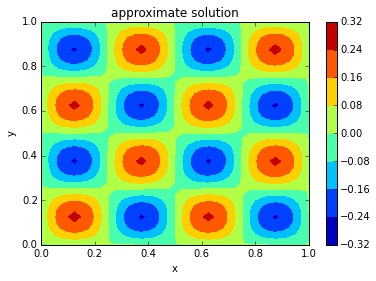

In [9]:
import matplotlib.pyplot as plt
plt.clf()
plt.tricontourf(x,y,triangles,u[:x.shape[0]])
plt.xlabel('x'); plt.ylabel('y')
plt.title('approximate solution'); plt.colorbar()
plt.show()
plt.savefig("c.png")

Compare to the exact solution, evaluated at the degrees of freedom. Again, only works for $C^0 P^1$ elements

In [10]:
import numpy as np
uex_vals = np.zeros(u.shape,'d')
uex_vals = uex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)

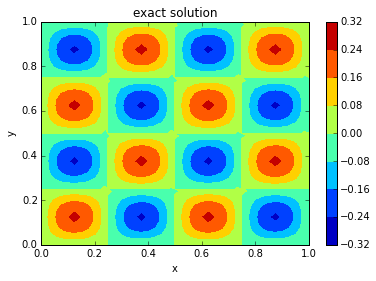

In [11]:
plt.clf()
plt.tricontourf(x,y,triangles,uex_vals)
plt.xlabel('x'); plt.ylabel('y')
plt.title('exact solution'); plt.colorbar()
plt.savefig("cex.png")

In [12]:
err = u-uex_vals
err *= err
err *= physics.L[0]*physics.L[1]/(numerics.nnx*numerics.nny)
L2approx = np.sqrt(err.sum())
print "Trapezoidal rule approx for error at dofs for nx=%s ny=%s is %s " % (numerics.nnx,numerics.nny,L2approx)

Trapezoidal rule approx for error at dofs for nx=41 ny=41 is 0.0024610786883 
